# Discovery Dataset but EPIC AML samples only

Playing in EPIC mode...

```{contents}
```

## Discovery (train) dataset sources

| Dataset | Reference | Disease | Raw Data Source | Download Sample Size | Population | Platform |
|---|---|---|---|---|---|---|
| COG_AAML1031 | [Aplenc et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32029509/) | AML | [GSE190931](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE190931) | 1048 | Pediatric | EPIC |
| COG_AAML0531 | [Gamis et al., 2014](https://pubmed.ncbi.nlm.nih.gov/25092781/) | AML | [GSE124413](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE124413) | 500 | Pediatric | EPIC |
| Japanese AML-05 | [Yamato et al., 2022](https://pubmed.ncbi.nlm.nih.gov/35008106/) | AML | [GSE133986](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133986) | 64 | Pediatric | EPIC |
| BeatAML | [Giacopelli et al., 2021](https://pubmed.ncbi.nlm.nih.gov/33707228/) | AML | [GSE159907](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE159907) | 316 | Adult | EPIC |

```{note}
These publicly available datasets were selected from GEO and GDC in 2023 based on the following criteria:

1. It must stem from a high-quality clinical trial or a large cohort study. 
2. It must contain clearly-labeled diagnostic leukemia samples from bone marrow or peripheral blood.
3. It must be available as raw methylation data (_.idat_ files) from methylation arrays (450k or EPIC).
```

## Step 1. Process raw data to get methylation beta values

This step will use SeSAMe ([Zhou et al. , 2018](https://pubmed.ncbi.nlm.nih.gov/30085201/)) to take signal intensity data (red and green .idat files) and convert them to beta values, which represent the % of methylation for each CpG site.

Process command:

    python -m methylprep -v process -d <directory> --all --batch_size 199
    

```{note}
From this point on we will move from using `python3.7` to using `python3.8`.
```

### Where the data at?

In [1]:
# See table above under column "Raw Data Source" to download the data.
input_path_EPIC = '/mnt/d/MethylScore/Raw_Data/Methyl_Array_EPIC/'

zhou2016_probes_path = '/mnt/d/MethylScore/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

output_path = '../../Data/Intermediate_Files/'

### Load and Merge Dataframes

In [2]:
import methylcheck
import pandas as pd

input_paths = [
    (input_path_EPIC, 'GSE190931'),      # COG_AAML1031
    (input_path_EPIC, 'GSE124413'),      # COG_AAML0531_03P1
    (input_path_EPIC, 'GSE133986'),      # Japanese AML-05
    (input_path_EPIC, 'GSE159907'),      # BeatAML
]

# Load the dataframes from the input paths
df = [methylcheck.load(path + name, silent=True) for path, name in input_paths]

# Concatenate the dataframes in the df list
df = pd.concat(df, keys= [name for _, name in input_paths] , axis=1, join='inner')

print(f' Dataset (df) contains {df.shape[0]} rows (5mC sites/probes) and {df.shape[1]} columns (samples).')

 Dataset (df) contains 865859 rows (5mC sites/probes) and 1928 columns (samples).


## Step 2. Remove suboptimal probes

There are several critera for exclusion of probes: Areas that have polymorphisms, cross-hybridization, repeat sequence elements, or base color changes can affect probe quality. Below are publications that have benchmarked probe quality and have provided lists of probes to exclude:

- [Chen et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3592906/)
- [Price et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3740789/)
- [Naeem et al., 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3943510/)
- [DacaRoszak et al., 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659175/)
- [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930)

This function removes proves listed as sub-optimal according to [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930). For the .tsv file containing the annotated probes, download the paper's supplementary material. See figure 5 of their paper for detailed description.

In [3]:
def exclude_suboptimal_probes(df):
    '''This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

    For the .tsv file containing the annotated probes, download the paper's
    supplementary material.
    '''
    # Load the list of suboptimal probes
    zhou2016_probes = pd.read_csv(zhou2016_probes_path, sep='\t',index_col=0)

    # Select the probes that are listed as suboptimal
    unreliable_probes = list(zhou2016_probes[zhou2016_probes['MASK.general'] == True].index)

    # Remove the unreliable probes from the dataframe
    df_ = df[~df.index.isin(unreliable_probes)]
    
    print(
        f'Removed {df.shape[0]-df_.shape[0]} suboptimal probes. {df_.shape[0]} probes remaining.')

    return(df_)

df = exclude_suboptimal_probes(df)

Removed 81915 suboptimal probes. 783944 probes remaining.


## Step 3. Remove sex-linked probes

In [4]:
df = methylcheck.exclude_sex_control_probes(df, 'epic', no_sex=True, no_control=False, verbose=True)

epic: Removed 17922 sex-linked probes from 1928 samples. 766022 probes remaining.


### Evaluate Missing Values

<Axes: >

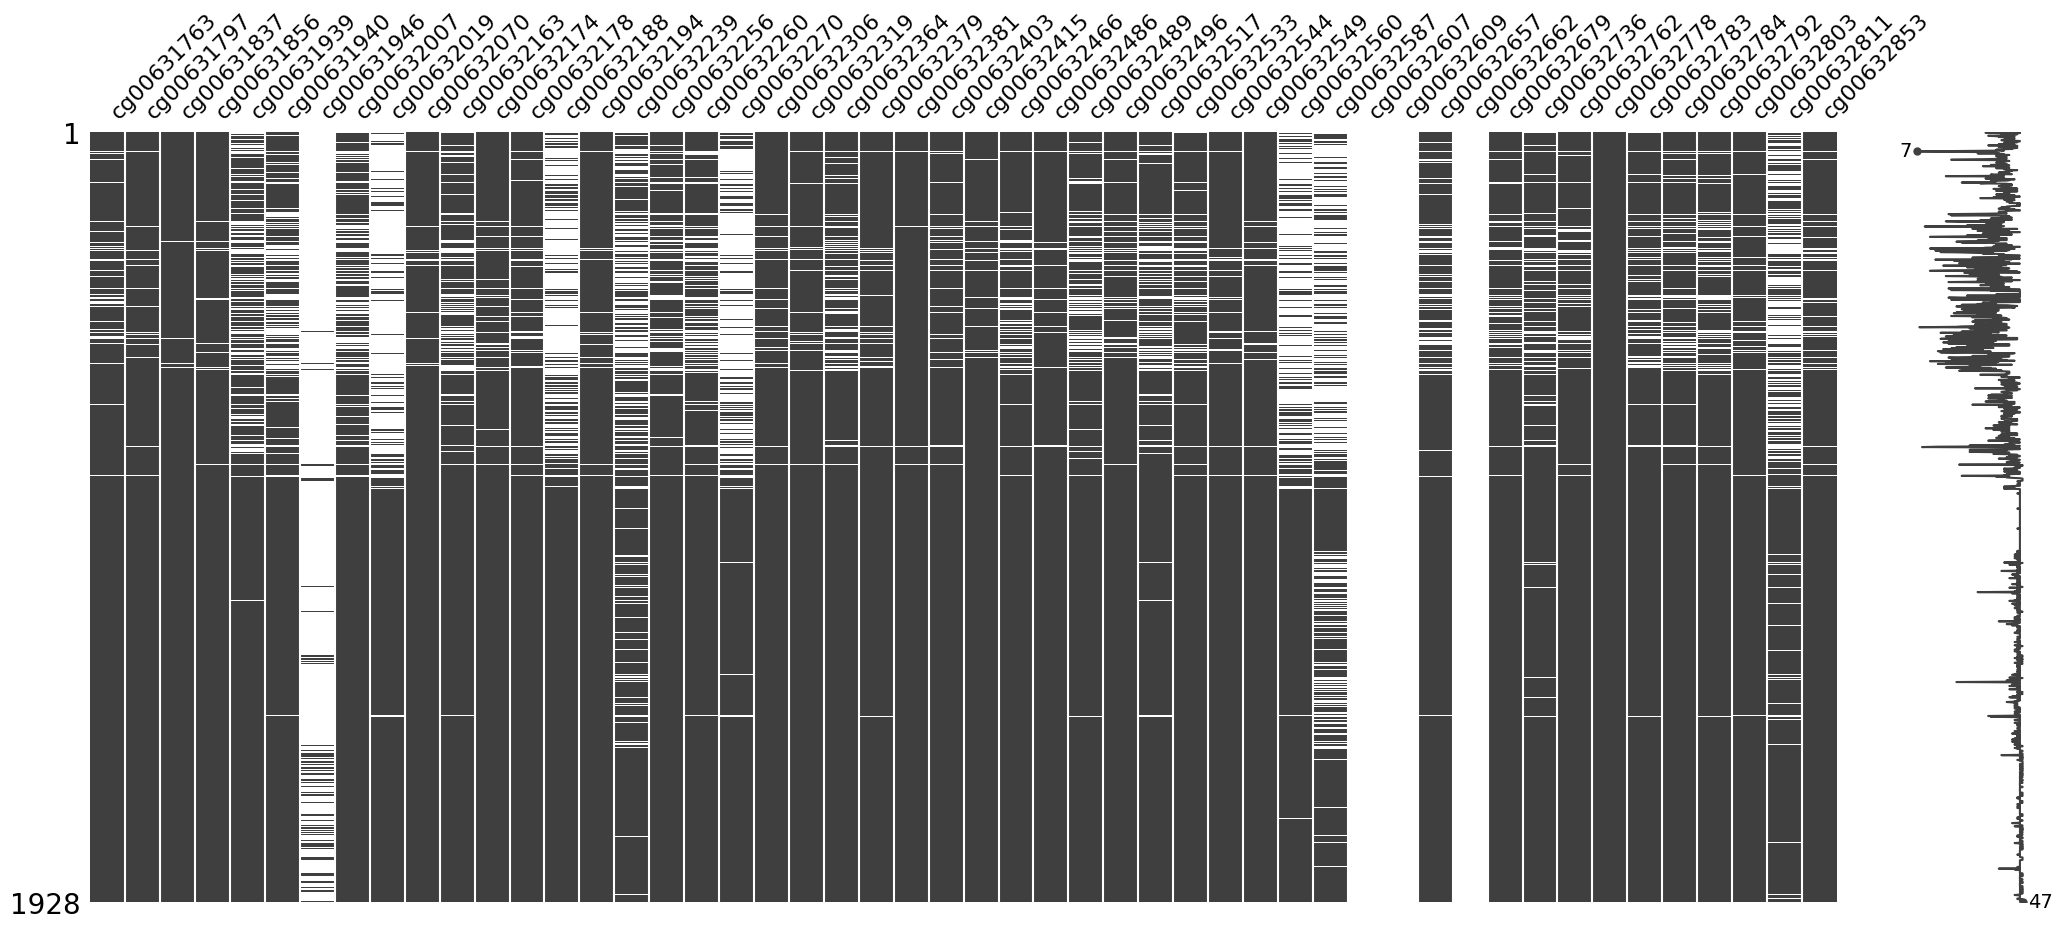

In [5]:
import missingno as msno

# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 4. Remove non-hematopoietic samples

In [6]:
print(
    f'0 non-hematopoietic samples removed. {df.shape[1]} samples remaining.')

0 non-hematopoietic samples removed. 1928 samples remaining.


## Step 5. Exclude samples in which >20% of probes have failed p-values

A strict metric implemented by Illumina quality control process is `FAIL by pval`, which happens if, for a given sample, the detection p-value is >0.05 in >20% of probes.

Recall that detection p-values measure how likely it is that signals are background fluorescence. There are a few methods for calculating these:  ```SeSAMe``` and ```methylprep``` implement pOOBAH, which stands for P-value Out Of Band (OOB) probes for Array Hybridization. For more, see SeSAMe's paper in [Zhou et al. , 2018](https://pubmed.ncbi.nlm.nih.gov/30085201/).

In other words, we will exclude samples that Illumina QC categorizes as FAIL(pval) for meeting the condition: (pOOBAH > 0.05) >20% probes. Here, failed probes are listed as `NaN`, so we will count the number of `NaN` values in each sample and exclude samples that have more than 20% `NaN` values.

In [7]:
def exclude_failed_samples(df2):
    '''This function removes samples that have more than 20% NaN values.'''

    # Calculate the number of NaN values in each sample
    nan_count = df2.isna().sum()

    # Calculate the total number of probes (rows) in the DataFrame
    total_probes = df2.shape[0]

    # Calculate the percentage of NaN values for each sample
    nan_percentage = (nan_count / total_probes) * 100

    # Identify samples that meet the condition of having more than 20% NaN values
    samples_to_exclude = nan_percentage[nan_percentage > 20].index

    # Exclude samples that meet the condition from the DataFrame
    filtered_df2 = df2.drop(samples_to_exclude, axis=1)
    
    # Print the number of samples before and after filtering
    print(
    f"Removed {df2.shape[1]-filtered_df2.shape[1]} samples ({round((df2.shape[1]-filtered_df2.shape[1])/df2.shape[1]*100,2)}%). {filtered_df2.shape[1]} samples remaining."
    )
    
    return filtered_df2

df = exclude_failed_samples(df)


Removed 534 samples (27.7%). 1394 samples remaining.


## Step 6. Exclude CpG probes that are missing in >5% of samples

In [8]:
def probe_cutoff(qc_betas, threshold):
    qc_betas2 = qc_betas.dropna(axis=0, thresh = int(threshold*qc_betas.shape[1]))
    print(f'{qc_betas.shape[0] - qc_betas2.shape[0]} probes removed. {qc_betas2.shape[0]} probes remaining.')

    return(qc_betas2)

df = probe_cutoff(df, threshold=0.95)

161031 probes removed. 604991 probes remaining.


### Evaluate Missing Values

<Axes: >

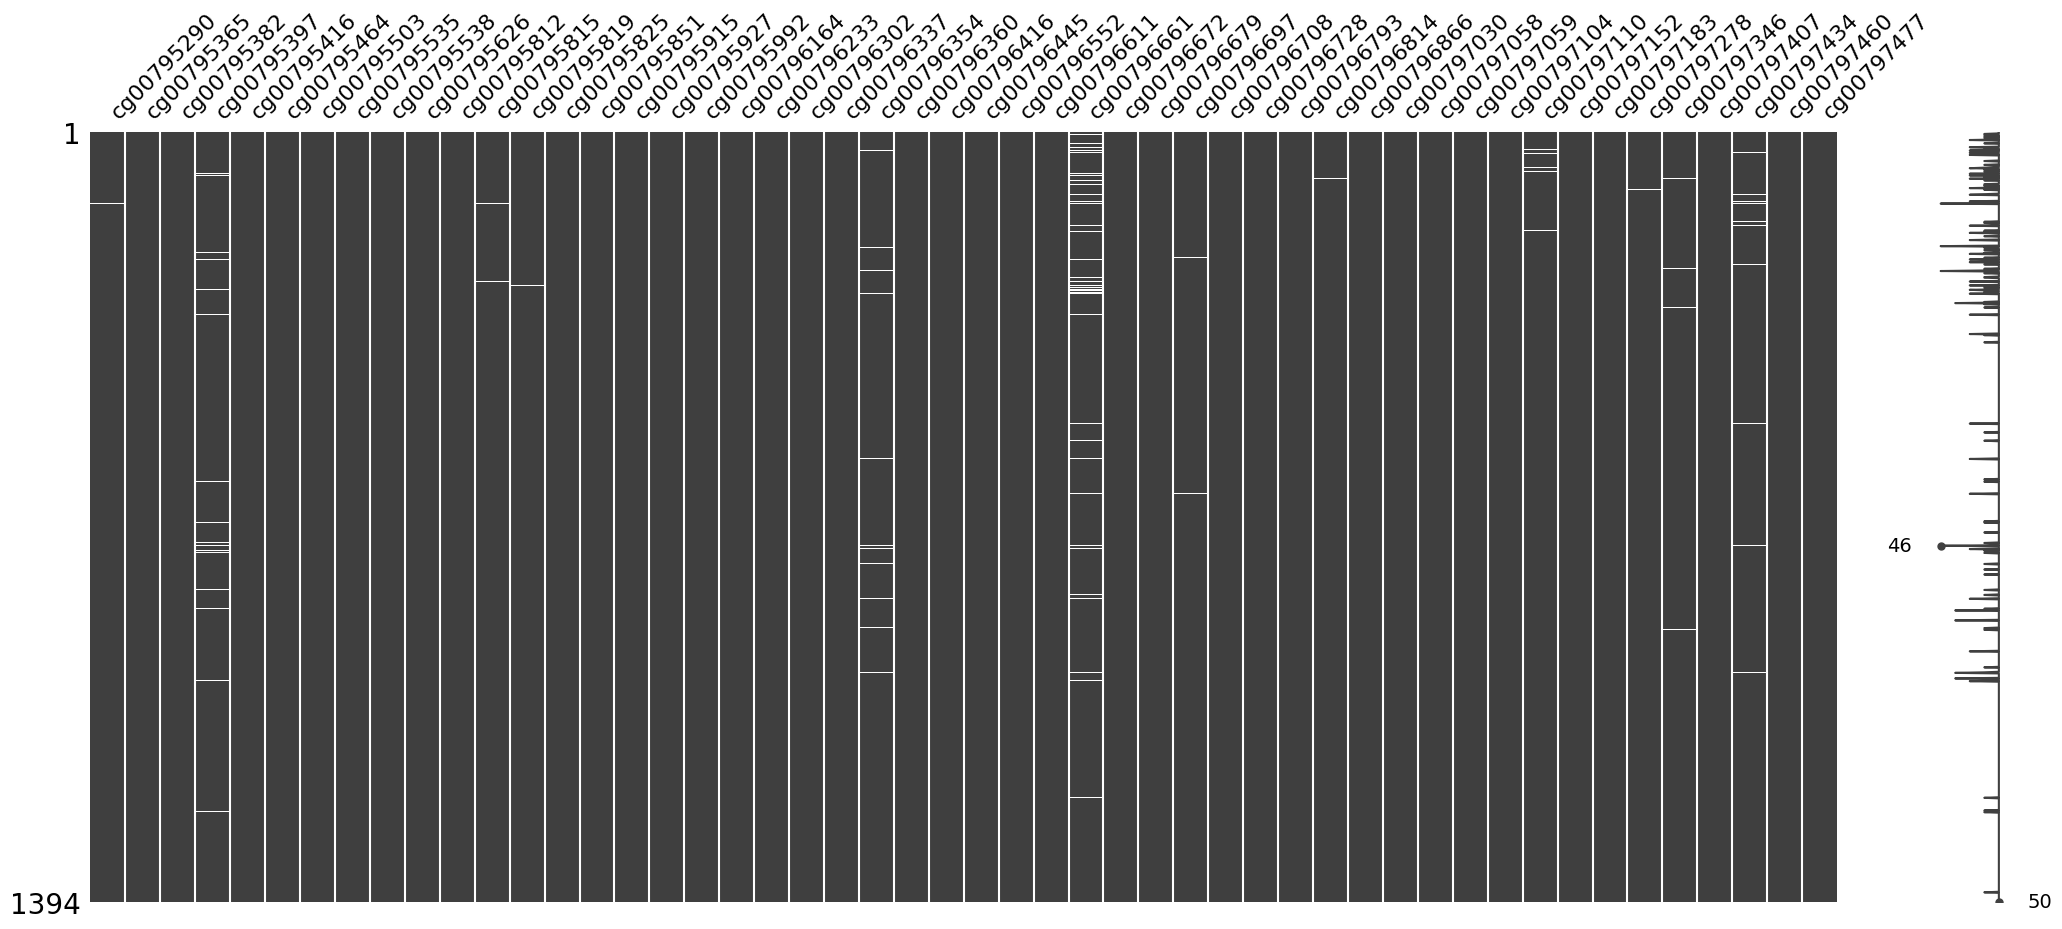

In [9]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 7. Impute remaining missing values

- __Method__: Mean by batch (it replaces each missing value by averaging all the known values for that CpG across samples within their batch).

- __Simple mean is recommended for methylation β-values__:

    _In conclusion, the consolidated and manufacturer encouraged practice to use β-value seems appropriate for DNA methylation data imputation. The choice of the best imputation method is somewhat more subtle and depends essentially on the available computational resources and the amount of missing values. Independently of the expected missingness mechanisms, regression-based methods provide on average more accurate estimates of the missing values. However, imputations with regression methods in the presence of limited computational resources can be a rather challenging task. In such cases, the simple mean approach can surprisingly be a better choice than more sophisticated methods_ ([Lena et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32600298/)).

- __This step inevitably introduces bias__: More sophisticated methods, however, also do. Benchmarks done by the paper above and others reported that the increase in error across methods is roughly similar ([see here](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)), which places `imputation by mean` as an equivalently error-prone method compared to others but vastly simpler and faster.

In [10]:
import pandas as pd

def impute_with_mean_of_batch(df):
    '''This function imputes missing values with the mean of the batch the sample belongs to.'''

    # Separate samples based on first level of the multi-index and fill NaNs with mean
    df_dict = {key: df[key].fillna(df[key].mean(axis=0)).round(3) for key in df.columns.levels[0]}
    
    # Merge the dataframes in multi-index format
    df2 = pd.concat(df_dict, axis=1, join='inner')
    
    print('NaN values filled by the mean probe value of the batch.')
    
    return df2

# Impute missing values
df = impute_with_mean_of_batch(df)


NaN values filled by the mean probe value of the batch.


### Evaluate Missing Values

<Axes: >

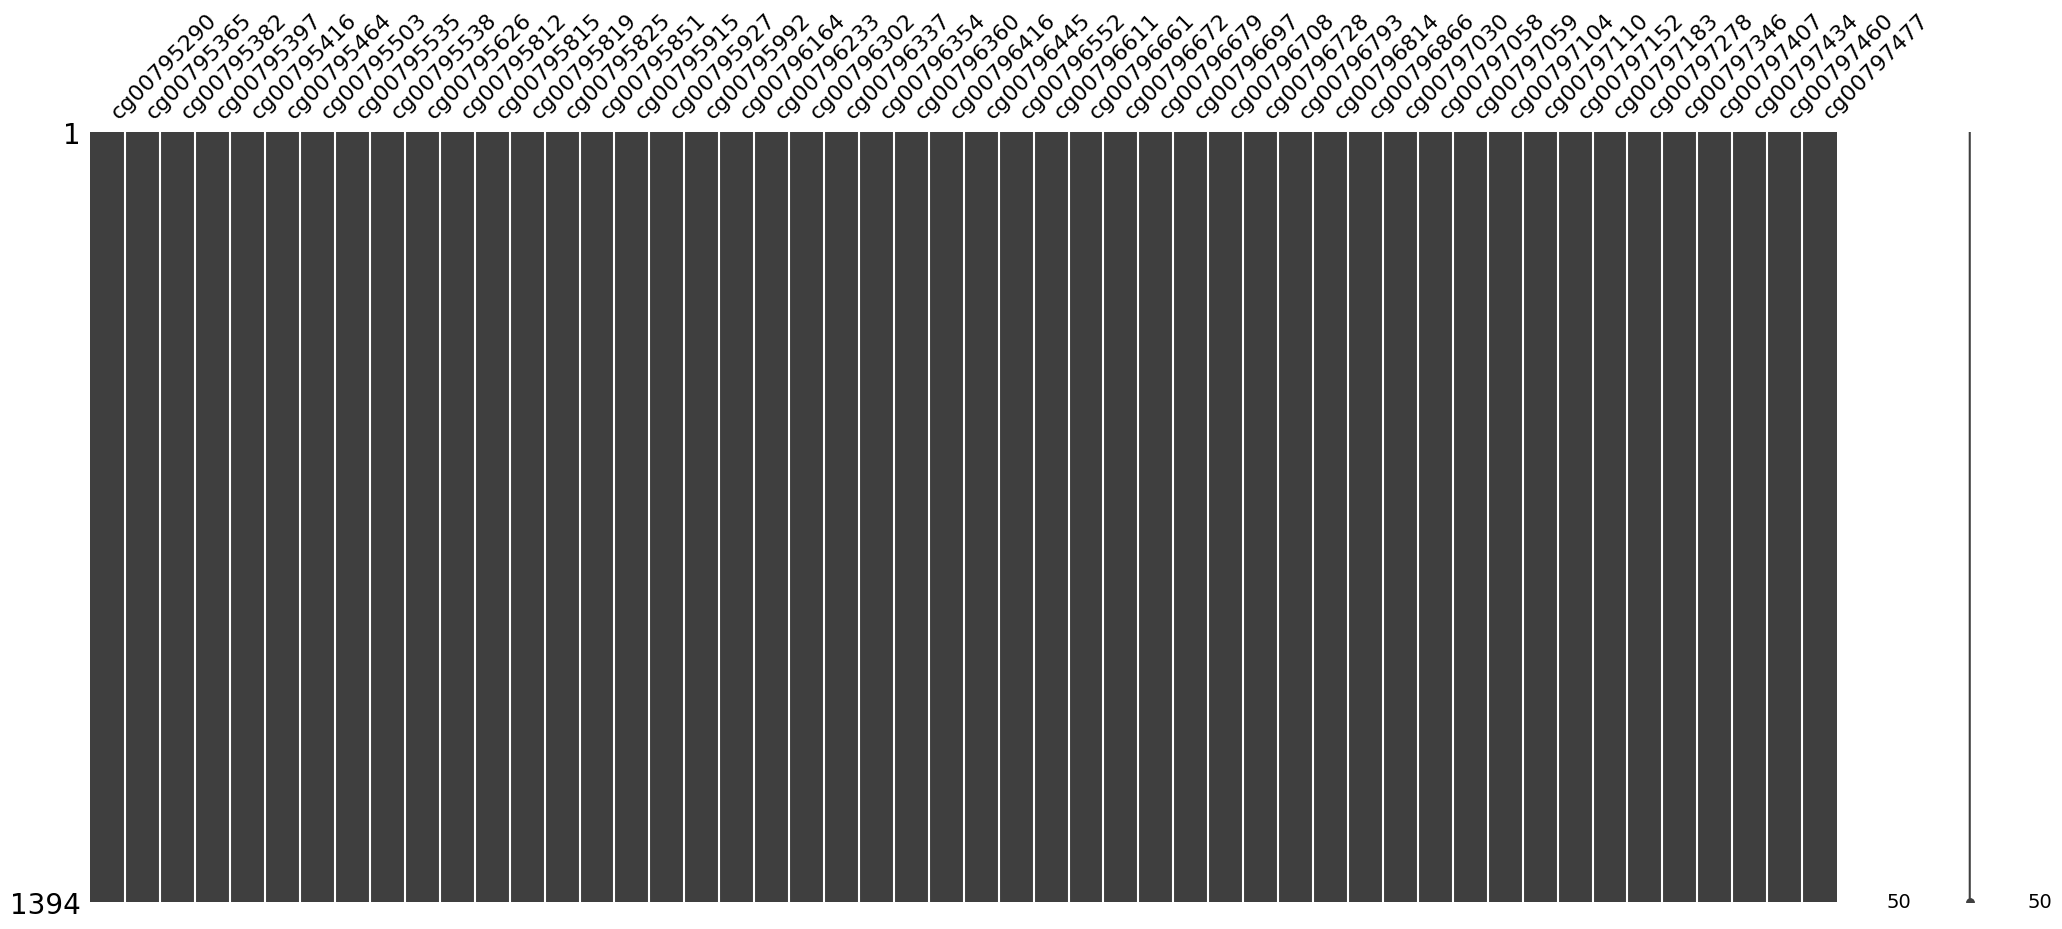

In [11]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 8. Remove outliers by PCA

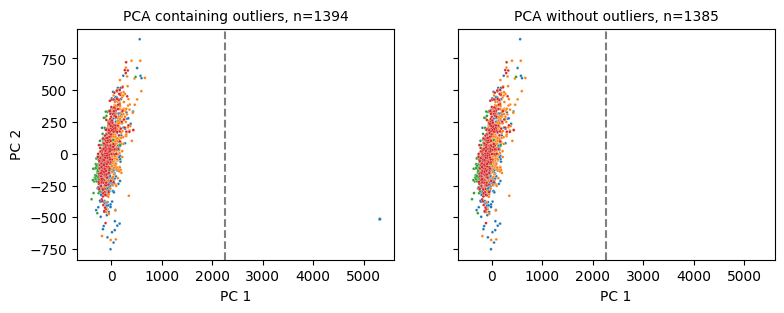

Removed 9 outliers. 1385 samples remaining.


[('GSE190931', '202905580033_R06C01'),
 ('GSE190931', '202905580033_R07C01'),
 ('GSE190931', '202905580033_R08C01'),
 ('GSE190931', '202908420004_R02C01'),
 ('GSE190931', '202908420004_R04C01'),
 ('GSE190931', '202908420004_R05C01'),
 ('GSE190931', '202908420004_R06C01'),
 ('GSE190931', '202908420004_R07C01'),
 ('GSE190931', '202908420004_R08C01')]

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define functions

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df.columns.get_level_values(0)
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

# Execute functions


X_std = standardize_data(df)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df)

# Define threshold to be > 5 standard deviations from the mean
threshold = principal_df['PC1'].std() * 5

non_outliers = principal_df[principal_df['PC1'] < threshold]
df = filter_df(df, principal_df, threshold)

# Plot the PCA data

def plot_data(principal_df, non_outliers, threshold):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
    
    for df, ax, title in [(principal_df, ax1,
                                     'PCA containing outliers, n=' + str(principal_df.shape[0])),
                                    (non_outliers, ax2,
                                     'PCA without outliers, n=' + str(non_outliers.shape[0]))]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=4, alpha=1, ax=ax, legend=False)
        ax.set_title(title, fontsize=10)
        ax.axvline(x=threshold, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
    plt.show()

plot_data(principal_df, non_outliers, threshold)
print(f'Removed {principal_df.shape[0]-df.shape[1]} outliers. {df.shape[1]} samples remaining.')

# List outliers

outliers = principal_df[principal_df['PC1'] >= threshold].index.to_list()
outliers

### Save dataset without batch correction

In [13]:
# df_batch_uncorrected = df.T.reset_index(level=0, names='Batch')
# df_batch_uncorrected.to_pickle(output_path + '3330samples-333351cpgs-nobatchcorrection-bvalues.pkl')

# print(
#     f'Successfuly saved in: {output_path}3330samples-333351cpgs-nobatchcorrection-bvalues.pkl')

## Step 9. Perform batch correction

- __pyCombat__: a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [14]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df = pycombat(data = df, batch = df.columns.droplevel(1)).round(3)

print('Succesfully corrected batch effects in the training dataset.')


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

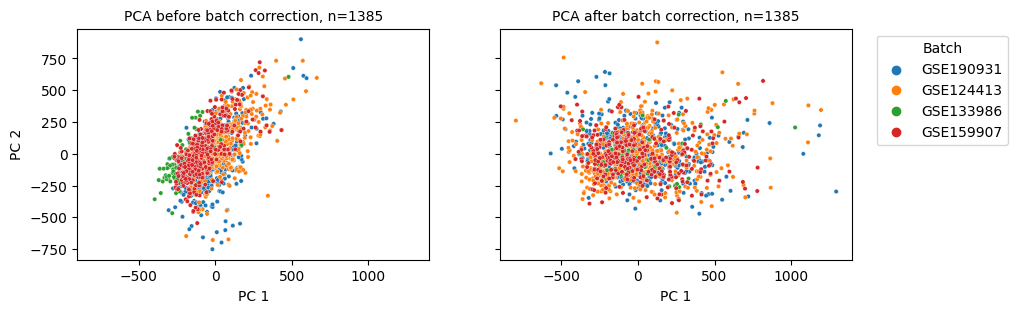

In [15]:
X_std = standardize_data(df)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(principal_df, non_outliers)


### Save batch-corrected dataset

In [16]:
df = df.T.reset_index(level=0, names='Batch')

df.to_pickle(output_path + '1385samples-604991cpgs-withbatchcorrection-bvalues.pkl')

print(
    f'Dataset (df) contains {df.shape[1]-1} rows (5mC nucleotides/probes) and {df.shape[0]} columns (samples).')
print(
    f'Successfuly saved in: {output_path}1385samples-604991cpgs-withbatchcorrection-bvalues.pkl')


Dataset (df) contains 604991 rows (5mC nucleotides/probes) and 1385 columns (samples).
Successfuly saved in: ../../Data/Intermediate_Files/1385samples-604991cpgs-withbatchcorrection-bvalues.pkl


## Step 10. Load and process clinical data

In [17]:
# Import functions to clean up clinical data
import sys
sys.path.insert(0, '..')
from source.clinical_data_cleanup_functions import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                        labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# Redefine output path (for troubleshooting purposes in case only this cell is run)
output_path = '../../Data/Intermediate_Files/'

# Read df
df = pd.read_pickle(output_path + '1385samples-604991cpgs-withbatchcorrection-bvalues.pkl')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df.index)].sort_index()

# Add age categorization and main disease classification to the clinical data
df_labels = process_df_labels(df_labels)

# Save the clinical data labels
df_labels.to_csv(output_path + 'discovery_clinical_data_EPIC.csv')

print('The clinical data has been indexed and cleaned.\n\
Exclusion of samples may be applied depending on the analysis.')

The clinical data has been indexed and cleaned.
Exclusion of samples may be applied depending on the analysis.


### WHO AML 2022 Diagnosis

In [18]:
df_labels['WHO AML 2022 Diagnosis'].value_counts()

WHO AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           243
AML with mutated NPM1                                                     162
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             146
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                142
MDS-related or secondary myeloid neoplasms                                 73
AML with NUP98-fusion                                                      62
AML with bZIP mutated CEBPA                                                58
Otherwise-Normal Control                                                   41
AML with CBFA2T3::GLIS2 (inv(16)(p13q24))                                  22
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     22
AML with ETV6 fusion                                                       13
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   13
AML with inv(3)(q21.3q26.2) or t(3;3)(q21

### ELN AML 2022 Diagnosis

In [19]:
df_labels['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           243
AML with mutated NPM1                                                     158
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             146
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                142
AML with other rare recurring translocations                              113
MDS-related or secondary myeloid neoplasms                                 74
AML with in-frame bZIP mutated CEBPA                                       58
Otherwise-Normal Control                                                   41
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     22
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   13
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement      8
Myeloid leukaemia associated with Down syndrome                             1
Mixed phenotype acute leukemia T/myeloid 

### Evaluate final sample size by batch

In [20]:
df['Batch'].value_counts(dropna=False)

Batch
GSE190931    516
GSE124413    491
GSE159907    315
GSE133986     63
Name: count, dtype: int64

## Appendix 1. How to download data from GEO or GDC

### Gene Expression Omnibus (GEO)

1. Install Python3.7

    - Go to [python.org](https://www.python.org/downloads/release/python-379/) and download python according to your operating system
    - During install, click on the box to enable it on PATH

2. Open a terminal (Windows: git bash, Linux/Mac: terminal)

    - Write the following commands to install methylprep:

    ```bash
    pip install --upgrade pip
    pip install methylprep==1.7.1
    ```

3. Download dataset of interest directly from GEO:

    ```bash
    python -m methylprep beta_bake -z -i <GEO series ID> -d <directory> 
    ```

```{note}
`methylprep` works best on Linux/Mac. API can be found [here](https://www.life-epigenetics-methylprep.readthedocs-hosted.com/en/latest/docs/cli.html).
```

### Genomic Data Commons (GDC)


1. Go to [GDC Repository](https://www.portal.gdc.cancer.gov/repository).
2. Select the right filtering criteria for you (or click on one of the links from the table above).
3. Once you have a selection of your samples, download the _Manisfest_ file by clicking on the _Manifest_ button.
4. Load them samples into your cart, go to cart page and download the _Sample Sheet_. This step is crucial to link sample IDs to the .idat files.
5. To download the data, you will need the GDC Data Transfer Tool (command-line) that you can find [here](https://www.gdc.cancer.gov/access-data/gdc-data-transfer-tool).
6. Follow the instructions on the link about how to download the file and use it.
7. As an example, on Windows, download the file and extract it to your data folder, then run:
    ```
    .\gdc-client download -m <path to the manisfest file you downloaded>.txt --no-related-files --no-annotations --latest
    ```
8. When the .idat files are downloaded, move them to Linux file system (to be used with WSL). If working on a Mac or native Linux, ignore this step.
9. Save the sample sheet file as _samplesheet.csv_ in the directory where the data are located. 
10. Extract .idat files from folders and remove .parcel files and empty folders:
    ```
    find . -mindepth 2 -type f -exec mv -t . -i '{}' +;
    find . -type f -name "*.parcel" -exec rm -f {} \;
    find . -mindepth 1 -type d -exec rm -rf {} \;
    ```
    
Congrats! You are ready to process the files using ```methylprep```.

## Appendix 2. How to create this electronic notebook

1. Use Jupyter Book

    - Go to [jupyterbook.org](https://jupyterbook.org).
    - Follow the steps on their page.

2. Set up `toc.yml` and `_config.yml` files

    - `toc.yml` is the table of contents file. It contains the structure of the book.
    - `_config.yml` is the configuration file. It contains the configuration of the book.

3. Build the book

    ```bash
    jb build .
    ```

4. Push to Github

    ```bash
    git add .
    git commit -m "message"
    git push
    ```
    or do it through VSCode GUI.

5. Push to Github pages using `ghp-import`

    ```bash
    ghp-import -n -p -f -o _build/html
    ```

```{note}
`jupyterbook` works best on Linux/Mac. If on Windows, use WSL.
```

## Watermark

In [21]:
%load_ext watermark

In [22]:
%watermark -v -p methylcheck,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylcheck: 0.8.5
pandas     : 2.0.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

